In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

In [2]:
income = pd.read_csv('./data/train_cleaned.csv')

## Feature Engineering

### Binarize the `sex` column

In [3]:
income['sex'] = np.where(income['sex'] == 'Male', 1, 0)

### Converting `fnlwgt` to a sample weight

In [4]:
# Creating a sample weight column, thanks Eric Heidbreder!
income['smpl_wgt'] = income['fnlwgt'].apply(lambda x: x / income['fnlwgt'].sum())

We tested the sample weight out with our models later, and it wasn't very good, so we abandoned this column eventually.

### Creating log_age column

Age benefited from a log transform, which converted it to a more normal distribution

In [5]:
# Log age, thanks Eric Heidbreder!
income['log_age'] = np.log(income['age'])

### Dummifying Features

In [7]:
# Dummifying Features, thanks Juhee Sung-Schenck!
income_d = pd.get_dummies(columns = ['workclass', 'education', 'marital-status', 'occupation', 'sex', 'native-country'], data=income, drop_first = True)

## Using LassoCV

In [8]:
income_d.drop(columns = ['relationship', 'log_age'], axis = 1, inplace = True)

# drop categorical variables that are not numeritized
income = income_d._get_numeric_data()

In [9]:
features = income._get_numeric_data().columns.drop('wage')
X = income[features]
y = income['wage']

In [10]:
income.shape

(32561, 93)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.258499728116476, tolerance: 0.3590967854217858
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.51927873137993, tolerance: 0.3560431971744475
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.13981371700743, tolerance: 0.35791064189189215
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWa

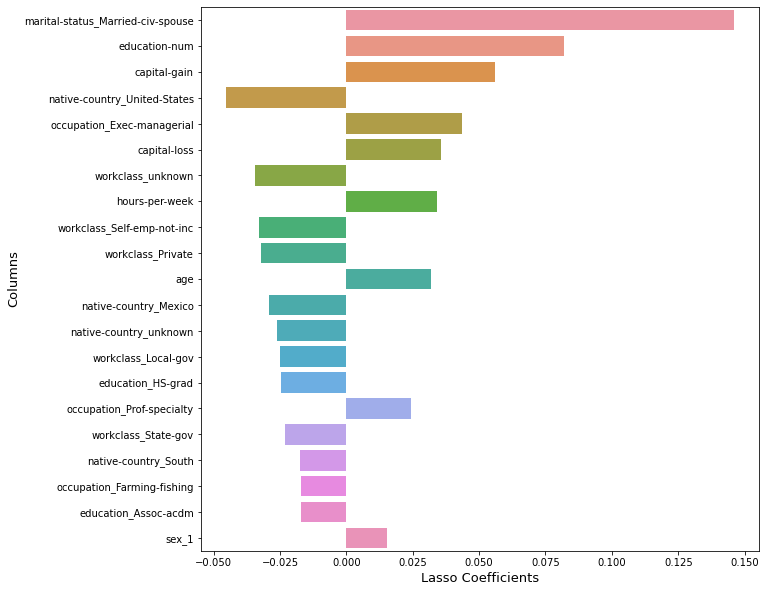

In [12]:
# scale the data and fit 
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

# Cross-validate over our list of Lasso alphas
alphas = np.linspace(0.000001, 3, num = 20)
lasso_cv = LassoCV(alphas=alphas, cv = 5)

# Fit model using best lasso alpha
lasso_cv.fit(Z_train, y_train)

# lasso coefficients to a dataframe
lasso_coef = pd.DataFrame({'column': X.columns, 'coef': lasso_cv.coef_})
lc = lasso_coef.iloc[lasso_coef.coef.abs().argsort()][::-1]

# make a horizontal bar plot to find out the most important factors
plt.figure(figsize = (10, 10))
sns.barplot(x = 'coef', y = 'column', data = lc[:21], orient = 'h')
plt.xlabel('Lasso Coefficients', size = 13)
plt.ylabel('Columns', size = 13)
plt.savefig('./images/lasso.png');

In [13]:
feature = list(lc['column'][:21])
income_dummy = income[feature]

In [14]:
income_dummy

,marital-status_Married-civ-spouse,education-num,capital-gain,native-country_United-States,occupation_Exec-managerial,capital-loss,workclass_unknown,hours-per-week,workclass_Self-emp-not-inc,workclass_Private,...,native-country_Mexico,native-country_unknown,workclass_Local-gov,education_HS-grad,occupation_Prof-specialty,workclass_State-gov,native-country_South,occupation_Farming-fishing,education_Assoc-acdm,sex_1
0,0,13,2174,1,0,0,0,40,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,13,0,1,1,0,0,13,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,9,0,1,0,0,0,40,0,1,...,0,0,0,1,0,0,0,0,0,1
3,1,7,0,1,0,0,0,40,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,13,0,0,0,0,0,40,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,1,12,0,1,0,0,0,38,0,1,...,0,0,0,0,0,0,0,0,1,0
32557,1,9,0,1,0,0,0,40,0,1,...,0,0,0,1,0,0,0,0,0,1
32558,0,9,0,1,0,0,0,40,0,1,...,0,0,0,1,0,0,0,0,0,0
32559,0,9,0,1,0,0,0,20,0,1,...,0,0,0,1,0,0,0,0,0,1


We've got 21 features now! Pretty good, let's save this dataframe and move on to the modeling notebook

In [15]:
income_dummy.to_csv('./data/train_modeling.csv', index = False)